# Setup

In [ ]:
!pip install fastai==2.7.10

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive

#you will have to change this for your own folder
drive.mount('/content/drive')
%cd /content/drive/My Drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive


# Processing training data

In [ ]:
from os import listdir

def remove_invalid(df):
    file_names = listdir('data/images')
    return df[df['image_id'].isin(file_names)]

In [ ]:
from fastai.vision.all import *
import pandas as pd

train_df = pd.read_csv('data/train.csv')
train_df = remove_invalid(train_df)


train_db = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                    splitter=TrainTestSplitter(),
                    get_x=ColReader(0, pref="data/images/"),
                    get_y=ColReader(1, label_delim=' '),
                    item_tfms=Resize(600, 'pad', 'border'), # 224
                    batch_tfms=aug_transforms())
print(train_db)
print(train_df)
dls = train_db.dataloaders(train_df, bs=16)

                            image_id  \
0                         img256.jpg   
1                          img98.jpg   
2                         img147.jpg   
3                         img254.jpg   
4                         img160.jpg   
..                               ...   
219                     IMG_8398.jpg   
220  Lodjaretk_lodjakojaga_large.jpg   
221                     IMG_2249.jpg   
222                         jm27.jpg   
223                  jommu_block.jpg   

                                                        labels  
0                                          l16 l18 l23 l25 l73  
1                                               l0 l24 l26 l39  
2                                                       l14 l3  
3                                                   l2 l25 l29  
4                                            l0 l32 l38 l40 l6  
..                                                         ...  
219  l38 l40 l0 l1 l2 l3 l6 l9 l10 l18 l19 l32 l34 l49 l61 l71  

In [ ]:
labels_df = pd.read_csv('data/labels.csv')
print(labels_df)

   label_id    object
0        l0    people
1        l1     trees
2        l2     grass
3        l3  building
4        l4      snow
..      ...       ...
87      l87     stage
88      l88      book
89      l89     books
90      l90      flag
91      l91      pole

[92 rows x 2 columns]


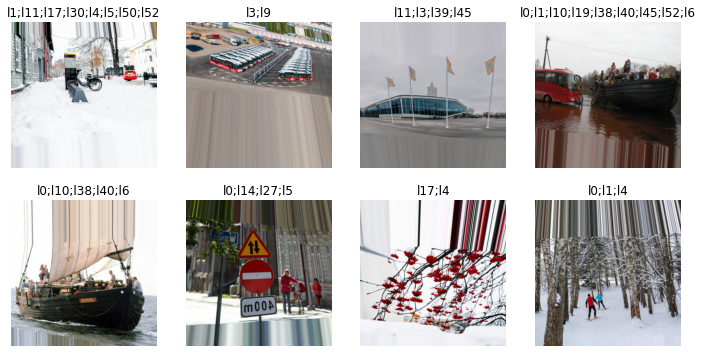

In [ ]:
dls.show_batch(max_n=8, figsize=(12,6))

# The good stuff

In [ ]:
learn = vision_learner(dls, models.resnet34, metrics=accuracy_multi, loss_func=BCEWithLogitsLossFlat())

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
class SAM(Callback):
    "Sharpness-Aware Minimization"
    def __init__(self, zero_grad=True, rho=0.05, eps=1e-12, **kwargs): 
        assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"
        self.state = defaultdict(dict)
        store_attr()

    def params(self): return self.learn.opt.all_params(with_grad=True)
    def _grad_norm(self): return torch.norm(torch.stack([p.grad.norm(p=2) for p,*_ in self.params()]), p=2)
    
    @torch.no_grad()
    def first_step(self):
        scale = self.rho / (self._grad_norm() + self.eps)
        for p,*_ in self.params():
            self.state[p]["e_w"] = e_w = p.grad * scale
            p.add_(e_w)  # climb to the local maximum "w + e(w)"
        if self.zero_grad: self.learn.opt.zero_grad()
        
    @torch.no_grad()    
    def second_step(self):
        for p,*_ in self.params(): p.sub_(self.state[p]["e_w"])

    def before_step(self, **kwargs):
        self.first_step()
        self.learn.pred = self.model(*self.xb); self.learn('after_pred')
        self.loss_func(self.learn.pred, *self.yb).backward()
        self.second_step()

In [ ]:
learn.fit_one_cycle(250, cbs=[SAM()])

epoch,train_loss,valid_loss,accuracy_multi,time
0,1.078077,0.859401,0.490366,00:09
1,1.073847,0.856180,0.509881,00:09
2,1.069393,0.863514,0.506670,00:09
3,1.066421,0.859454,0.509881,00:09
4,1.061808,0.861315,0.507905,00:09
5,1.057329,0.843610,0.519022,00:09
6,1.054633,0.846499,0.516551,00:09
7,1.053278,0.840407,0.518281,00:10
8,1.050074,0.838996,0.516057,00:09
9,1.043972,0.830146,0.516798,00:09


In [ ]:
test_df = pd.read_csv('data/test.csv')
print(test_df)

      image_id
0   img102.jpg
1   img103.jpg
2    img11.jpg
3   img113.jpg
4   img114.jpg
..         ...
83   img81.jpg
84   img84.jpg
85   img90.jpg
86   img93.jpg
87   img94.jpg

[88 rows x 1 columns]


image_id          img170.jpg
labels      l0 l1 l21 l3 l83
Name: 20, dtype: object


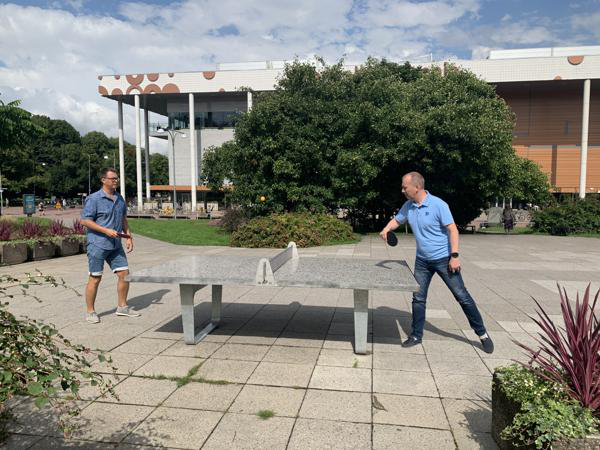

In [ ]:
img_series = test_df.sample().iloc[0]
print(img_series)

img_path = 'data/images/' + img_series['image_id']

img = load_image(img_path)
img

In [ ]:
pred_class,pred_idx,outputs = learn.predict(img_path)
list(map(lambda label: labels_df.loc[labels_df['label_id'] == label], pred_class))

[  label_id  object
 0       l0  people,   label_id object
 1       l1  trees,    label_id      object
 21      l21  stone road,   label_id    object
 3       l3  building,    label_id object
 83      l83  table]

In [ ]:
file_names = listdir('data/images')
for i in test_df.index:
  if test_df.at[i, 'image_id'] in file_names:
    img_path = 'data/images/' + test_df.at[i, 'image_id']
    print(img_path)
    pred_class,pred_idx,outputs = learn.predict(img_path)
    print(pred_class)
    test_df.at[i, 'labels'] = ' '.join(pred_class)
  else:
    test_df.at[i, 'labels'] = ''
print(test_df)

data/images/img102.jpg


['l0']
data/images/img103.jpg


['l1', 'l7']
data/images/img11.jpg


['l4']
data/images/img113.jpg


['l1', 'l6']
data/images/img114.jpg


['l13']
data/images/img121.jpg


['l0', 'l1', 'l2', 'l31', 'l34', 'l5', 'l54', 'l6']
data/images/img126.jpg


['l0', 'l2', 'l6']
data/images/img131.jpg


[]
data/images/img136.jpg


[]
data/images/img137.jpg


['l1', 'l4']
data/images/img139.jpg


['l1', 'l3', 'l4', 'l59']
data/images/img140.jpg


['l0', 'l1', 'l22']
data/images/img15.jpg


['l53', 'l91']
data/images/img150.jpg


[]
data/images/img151.jpg


['l0', 'l1']
data/images/img152.jpg


['l0', 'l14', 'l5', 'l7']
data/images/img156.jpg


['l1', 'l5', 'l7']
data/images/img161.jpg


['l0', 'l1', 'l10', 'l38', 'l40', 'l6']
data/images/img166.jpg


['l1', 'l8']
data/images/img167.jpg


['l9']
data/images/img170.jpg


['l0', 'l1', 'l21', 'l3', 'l83']
data/images/img173.jpg


['l1', 'l4']
data/images/img176.jpg


['l0', 'l1', 'l4']
data/images/img18.jpg


['l0', 'l1', 'l2']
data/images/img180.jpg


['l0', 'l1', 'l30', 'l5']
data/images/img181.jpg


['l0', 'l1', 'l10', 'l11', 'l7']
data/images/img182.jpg


['l0', 'l1', 'l3', 'l7']
data/images/img183.jpg


['l2', 'l20', 'l7']
data/images/img189.jpg


['l0', 'l1', 'l20', 'l6']
data/images/img192.jpg


['l0', 'l1', 'l11', 'l7']
data/images/img194.jpg


['l0', 'l1', 'l2']
data/images/img195.jpg


['l0']
data/images/img206.jpg


['l0', 'l1', 'l12', 'l2']
data/images/img208.jpg


['l1']
data/images/img209.jpg


['l1', 'l10', 'l2']
data/images/img211.jpg


['l1', 'l15', 'l18', 'l2', 'l3', 'l5', 'l7']
data/images/img212.jpg


['l1', 'l15', 'l2', 'l7']
data/images/img218.jpg


['l30', 'l70', 'l78', 'l8', 'l88']
data/images/img22.jpg


['l1', 'l18', 'l2', 'l21', 'l71']
data/images/img221.jpg


[]
data/images/img228.jpg


['l1', 'l4', 'l42', 'l69']
data/images/img230.jpg


['l1', 'l3', 'l4', 'l42', 'l9']
data/images/img231.jpg


['l1', 'l4']
data/images/img234.jpg


['l1', 'l3', 'l4', 'l42', 'l9']
data/images/img238.jpg


['l0', 'l11']
data/images/img243.jpg


['l0', 'l1']
data/images/img247.jpg


['l1', 'l2', 'l3', 'l9']
data/images/img248.jpg


[]
data/images/img249.jpg


[]
data/images/img250.jpg


[]
data/images/img251.jpg


['l11', 'l7']
data/images/img252.jpg


['l5']
data/images/img257.jpg


['l1', 'l7']
data/images/img259.jpg


['l3']
data/images/img262.jpg


['l0']
data/images/img265.jpg


['l34']
data/images/img266.jpg


['l1', 'l15', 'l5', 'l7', 'l9']
data/images/img279.jpg


['l0', 'l5']
data/images/img280.jpg


['l0', 'l5']
data/images/img281.jpg


['l0', 'l1', 'l24']
data/images/img292.jpg


['l0', 'l5']
data/images/img296.jpg


['l24', 'l26', 'l28']
data/images/img3.jpg


['l17', 'l27', 'l3']
data/images/img300.jpg


['l28', 'l3', 'l48', 'l6']
data/images/img33.jpg


['l0']
data/images/img37.jpg


['l1']
data/images/img39.jpg


['l8']
data/images/img41.jpg


['l0', 'l1']
data/images/img42.jpg


[]
data/images/img43.jpg


[]
data/images/img48.jpg


['l3', 'l45', 'l52', 'l7', 'l9']
data/images/img49.jpg


['l0', 'l1', 'l15']
data/images/img5.jpg


['l0', 'l17', 'l27', 'l4', 'l58', 'l63', 'l79']
data/images/img57.jpg


[]
data/images/img59.jpg


['l14', 'l7', 'l9']
data/images/img69.jpg


['l0', 'l1', 'l41', 'l86']
data/images/img71.jpg


['l0']
data/images/img73.jpg


['l0']
data/images/img75.jpg


['l0']
data/images/img79.jpg


[]
data/images/img8.jpg


[]
data/images/img81.jpg


['l2']
data/images/img84.jpg


['l13', 'l60', 'l75']
data/images/img90.jpg


['l0']
data/images/img93.jpg


[]
data/images/img94.jpg


['l13']
      image_id       labels
0   img102.jpg           l0
1   img103.jpg        l1 l7
2    img11.jpg           l4
3   img113.jpg        l1 l6
4   img114.jpg          l13
..         ...          ...
83   img81.jpg           l2
84   img84.jpg  l13 l60 l75
85   img90.jpg           l0
86   img93.jpg             
87   img94.jpg          l13

[88 rows x 2 columns]


In [ ]:
test_df.to_csv('data/submission.csv', index = False)

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kristoisberg","key":"e896f3fc0e72d1ac41b5c41a2585a55a"}'}

In [ ]:
import json

!mkdir /root/.kaggle/
!mv kaggle.json /root/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}

mkdir: cannot create directory ‘/root/.kaggle/’: File exists
- path is now set to: {/content}


In [ ]:
!kaggle competitions submit -c tartu-object-detection-part-2 -f data/submission.csv -m "FastAI v2 submission with larger training set"

100% 1.62k/1.62k [00:00<00:00, 3.07kB/s]
Successfully submitted to Object recognition for The Image Bank of Tartu (2)